In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

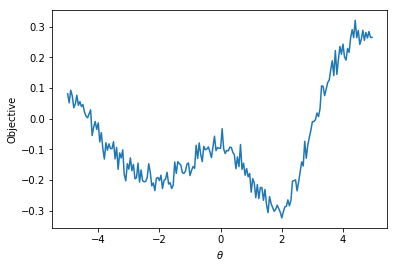

In [2]:
def objective(theta):
    theta = np.atleast_1d(theta)
    y = -0.5 * np.exp(-0.5*(theta - 2)**2) - 0.5 * np.exp(-0.5 * (theta + 2.1)**2 / 5) + 0.3
    np.random.seed(9458)
    return y + 0.025*np.random.randn(len(theta))

t = np.linspace(-5, 5, 5000)

plt.plot(t[::25], objective(t[::25]))
plt.xlabel('$\\theta$')
plt.ylabel('Objective')
plt.show()

In [3]:
from george import GP, kernels
from scipy.special import erf
from scipy.optimize import minimize

iteration = 1
train_theta = np.array([0])

In [4]:
train_f = objective(train_theta)
gp = GP(kernels.Matern52Kernel(3.0), fit_mean=True, fit_white_noise=True)
gp.compute(train_theta)

In [5]:
mu, var = gp.predict(train_f, t, return_var=True)
std = np.sqrt(var)

In [6]:
def nll(params):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(train_f, quiet=True)
    grad = gp.grad_log_likelihood(train_f, quiet=True)
    return -ll, -grad

soln = minimize(nll, x0=gp.get_parameter_vector(), jac=True)
gp.set_parameter_vector(soln.x)

In [7]:
f_min = np.min(train_f)
chi = (f_min - mu) / std
Phi = 0.5 * (1.0 + erf(chi / np.sqrt(2)))
phi = np.exp(-0.5 * chi**2) / np.sqrt(2*np.pi*var)
A_ei = (f_min - mu) * Phi + var * phi
A_max = t[np.argmax(A_ei)]

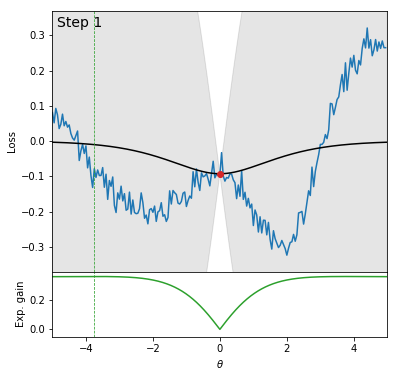

In [8]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,6), gridspec_kw = {'height_ratios':[4, 1]})

ax1.plot(t[::25], objective(t[::25]))
ax1.plot(t, mu, 'k')
ax1.fill_between(t, mu+std, mu-std, color='k', alpha=.1)
ax1.plot(train_theta, train_f, 'o', color='C3')
ax1.axvline(A_max, linestyle='--', color='C2', lw=0.75)

ax1.set_xlim(-5, 5)
ax1.set_ylim(-.37, .37)
ax1.set_ylabel('Loss')
ax1.annotate('Step {}'.format(iteration), xy=(0, 1), xycoords='axes fraction', ha='left', va='top', xytext=(5, -5), textcoords='offset points', fontsize=14)

ax2.plot(t, A_ei, 'C2')
ax2.axvline(A_max, linestyle='--', color='C2', lw=0.75)

ax2.set_ylim(-.05, 0.39)
ax2.set_xlabel('$\\theta$')
ax2.set_ylabel('Exp. gain')

f.subplots_adjust(hspace=0)
f.savefig('opt/step{}.pdf'.format(iteration), bbox_inches='tight')

In [9]:
iteration += 1
train_theta = np.append(train_theta, A_max)